In [1]:
import datetime as dt  
from datetime import timedelta
import matplotlib.pyplot as plt 
from matplotlib import style
import matplotlib.dates as mdates
from mpl_finance import candlestick_ochl
import matplotlib.dates as mdates
import pandas as pd 
import pandas_datareader as pdr 
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
import numpy as np
from collections import Counter
import os
import bs4 as bs 
import pickle
import requests 
from sklearn import svm, neighbors
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts 
style.use('ggplot')
register_matplotlib_converters()

In [2]:
# these are the companies we are interested in, so we will hard code the tickers in this array 
tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']

months = mdates.MonthLocator()

# tickers = ['SOXL','GUSH']
# pandemics = ['test']
# testing for GUSH 2015-05-29
# start1 = dt.datetime(2015,5,29)
# end1 = dt.datetime(2020,4,29)


In [35]:
# variables we will need
# datetime(year, month, day) 
sars = 'sars'
start_sars = dt.datetime(2002,10,1)
end_sars = dt.datetime(2004,1,1)

swine = 'swine'
start_swine = dt.datetime(2009,4,15)
end_swine = dt.datetime(2010,8,11)

ebola = 'ebola'
start_ebola = dt.datetime(2013,12,1)
end_ebola = dt.datetime(2016,1,14)

corona = 'corona'
start_corona = dt.datetime(2019,11,17)
end_corona = dt.datetime(2020,4,24)

pandemics = [sars,swine,ebola,corona]

# train
start_train = dt.datetime(2000,1,1)
end_train = dt.datetime(2020,4,20)
train = 'train'

# test
start_test = dt.datetime(2020,4,20)
end_test = dt.datetime(2020,5,1)
test = 'test'

In [36]:
######### get the data for each time period of the corresponding pandemic 
def get_data_from_yahoo_pandemic(pandemic,start,end):
    # with open('sp500tickers.pickle','rb') as f:
    #         tickers = pickle.load(f)
    if not os.path.exists('stock_dfs_{}'.format(pandemic)):
        os.makedirs('stock_dfs_{}'.format(pandemic))

    # tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']
    # start = dt.datetime(2002,10,1)
    # end = dt.datetime(2003,9,1)


    # to test use tickers[:10] so you don't have to wiat for all 500
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs_{}/{}.csv'.format(pandemic,ticker)):
            try:
                df = web.DataReader(ticker,'yahoo',start,end)
                df.to_csv('stock_dfs_{}/{}.csv'.format(pandemic,ticker))
            except KeyError:
                pass
        else:
            print('Already have {}'.format(ticker))

In [37]:
# sars
get_data_from_yahoo_pandemic(sars,start_sars,end_sars)

# swine
get_data_from_yahoo_pandemic(swine,start_swine,end_swine)

# ebola
get_data_from_yahoo_pandemic(ebola,start_ebola,end_ebola)

# corona
get_data_from_yahoo_pandemic(corona,start_corona,end_corona)

# test for some other data we are interested in 
get_data_from_yahoo_pandemic(test,start_test,end_test)
get_data_from_yahoo_pandemic(train,start_train,end_train)

AAPL
Already have AAPL
AXP
Already have AXP
NKE
Already have NKE
CVX
Already have CVX
JNJ
Already have JNJ
F
Already have F
ALK
Already have ALK
AAPL
Already have AAPL
AXP
Already have AXP
NKE
Already have NKE
CVX
Already have CVX
JNJ
Already have JNJ
F
Already have F
ALK
Already have ALK
AAPL
Already have AAPL
AXP
Already have AXP
NKE
Already have NKE
CVX
Already have CVX
JNJ
Already have JNJ
F
Already have F
ALK
Already have ALK
AAPL
Already have AAPL
AXP
Already have AXP
NKE
Already have NKE
CVX
Already have CVX
JNJ
Already have JNJ
F
Already have F
ALK
Already have ALK
AAPL
AXP
NKE
CVX
JNJ
F
ALK
AAPL
AXP
NKE
CVX
JNJ
F
ALK


In [6]:
########### combine each dataset into one csv
def compile_data_pandemic(pandemic):
    # with open("sp500tickers.pickle","rb") as f:
    #     tickers = pickle.load(f)

    main_df = pd.DataFrame()
    # tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']
    for count,ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs_{}/{}.csv'.format(pandemic,ticker))
            df.set_index('Date',inplace=True)

            df.rename(columns = { 'Adj Close': ticker}, inplace=True)
            df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how = 'outer')
            
            if count % 10 == 0:
                # print(count)
                pass
        except FileNotFoundError as e:
            print('no file')
            continue
    main_df.to_csv('stock_dfs_{}/{}.csv'.format(pandemic,pandemic))
    return main_df

In [38]:
# sars 
sars_df = compile_data_pandemic(sars)
# swine
swine_df = compile_data_pandemic(swine)
# ebola
ebola_df = compile_data_pandemic(ebola)
# corona
corona_df = compile_data_pandemic(corona)

# train 
train_df = compile_data_pandemic(train)

# test
test_df = compile_data_pandemic(test)

In [8]:
# sars_df.shape
# sars_df.head()

In [9]:
############# process data for labels ... 

def process_data_for_labels(pandemic,ticker):
    # how many days 
    days = 7 
    df = pd.read_csv('stock_dfs_{}/{}.csv'.format(pandemic,pandemic), index_col=0)
    # df = pd.read_csv('sars_data.csv', index_col=0)

    tickers = df.columns.values.tolist()
    df.fillna(0,inplace=True)

    for i in range(1, days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0,inplace=True)
    return tickers,df

In [10]:
# tick, df_test = process_data_for_labels(corona,tickers[0])

In [11]:
# df_test.shape
# df_test.tail()

In [12]:
############# ml target function 
def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = .02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1

    return 0

In [13]:
def extract_feature_sets(pandemic,ticker):
    tickers, df = process_data_for_labels(pandemic,ticker)
    hm_days=7
    df['{}_target'.format(ticker)] = list(map( buy_sell_hold, df['{}_1d'.format(ticker)],
        df['{}_2d'.format(ticker)],
        df['{}_3d'.format(ticker)],
        df['{}_4d'.format(ticker)],
        df['{}_5d'.format(ticker)],
        df['{}_6d'.format(ticker)],
        df['{}_7d'.format(ticker)]
        ))
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread: ',Counter(str_vals))
    df.fillna(0,inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df_vals = df[[ticker for ticker in tickers ]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf],0)
    df_vals.fillna(0, inplace=True)
    X=df_vals.values
    y=df['{}_target'.format(ticker)].values
    return X,y

In [14]:
# x,y=extract_feature_sets(corona,tickers[0])

In [15]:
########### actual ml 
# confidence_levels = []
def do_ml(pandemic,ticker):
    X,y=extract_feature_sets(pandemic,ticker)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)


    # K nearest neighbors
    # clf = neighbors.KNeighborsClassifier()
    # clf1 = svm.LinearSVC()
    # clf2 = RandomForestClassifier()
    # voting classifier
    clf = VotingClassifier([
        ('lsvc', svm.LinearSVC()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('rfor', RandomForestClassifier())
    ])



    clf.fit(X_train,y_train) 
    confidence = clf.score(X_test,y_test)
    print('Accuracy:',confidence)
    predictions = clf.predict(X_test)
    print('Predicted spread:',Counter(predictions))

    return confidence

In [44]:
for ticker in tickers:
    print(ticker)
    for pandemic in pandemics:
        print(pandemic)
        do_ml(pandemic,ticker)
        print('\n')
    print('\n\n')

AAPL
sars
Data spread:  Counter({'1': 160, '-1': 146, '0': 10})
Accuracy: 0.5063291139240507
Predicted spread: Counter({1: 56, -1: 23})


swine
Data spread:  Counter({'1': 183, '-1': 122, '0': 30})
Accuracy: 0.4166666666666667
Predicted spread: Counter({1: 66, -1: 18})


ebola
Data spread:  Counter({'1': 221, '-1': 211, '0': 102})
Accuracy: 0.35074626865671643
Predicted spread: Counter({1: 67, -1: 64, 0: 3})


corona
Data spread:  Counter({'1': 62, '-1': 39, '0': 8})
Accuracy: 0.4642857142857143
Predicted spread: Counter({1: 23, -1: 4, 0: 1})





AXP
sars
Data spread:  Counter({'1': 147, '-1': 131, '0': 38})
Accuracy: 0.3924050632911392
Predicted spread: Counter({1: 52, -1: 26, 0: 1})


swine
Data spread:  Counter({'1': 191, '-1': 122, '0': 22})
Accuracy: 0.5476190476190477
Predicted spread: Counter({1: 63, -1: 21})


ebola
Data spread:  Counter({'-1': 205, '0': 173, '1': 156})
Accuracy: 0.3283582089552239
Predicted spread: Counter({-1: 110, 0: 16, 1: 8})


corona
Data spread:  Counte

## predictions

In [30]:
########### actual ml 
# confidence_levels = []
def do_ml2(pandemic,ticker):
    X,y=extract_feature_sets(pandemic,ticker)

    # X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)


    # K nearest neighbors
    # clf = neighbors.KNeighborsClassifier()
    # clf1 = svm.LinearSVC()
    # clf2 = RandomForestClassifier()
    # voting classifier
    clf = VotingClassifier([
        ('lsvc', svm.LinearSVC()),
        ('knn', neighbors.KNeighborsClassifier()),
        ('rfor', RandomForestClassifier())
    ])



    clf.fit(X,y) 
    # confidence = clf.score(X_test,y_test)
    # print('Accuracy:',confidence)
    # predictions = clf.predict(X_test)
    # print('Predicted spread:',Counter(predictions))

    return clf

## test for AAPL

In [39]:
test_model = do_ml2(train,'AAPL')
x_test,y_test = extract_feature_sets(test,'AAPL')
pred = test_model.predict(x_test)

Data spread:  Counter({'1': 2532, '-1': 2074, '0': 500})
Data spread:  Counter({'1': 7, '0': 2, '-1': 1})


## test for AXP

In [40]:
test_model = do_ml2(train,'AXP')
x_test,y_test = extract_feature_sets(test,'AXP')
pred = test_model.predict(x_test)

Data spread:  Counter({'1': 2168, '-1': 1863, '0': 1075})
Data spread:  Counter({'1': 6, '-1': 3, '0': 1})


## test for NKE

In [41]:
test_model = do_ml2(train,'NKE')
x_test,y_test = extract_feature_sets(test,'NKE')
pred = test_model.predict(x_test)

Data spread:  Counter({'1': 2312, '-1': 1778, '0': 1016})
Data spread:  Counter({'-1': 6, '1': 2, '0': 2})


## test for CVX

In [42]:
test_model = do_ml2(train,'CVX')
x_test,y_test = extract_feature_sets(test,'CVX')
pred = test_model.predict(x_test)

Data spread:  Counter({'1': 2162, '-1': 1778, '0': 1166})
Data spread:  Counter({'1': 6, '-1': 3, '0': 1})


## test for JNJ

In [43]:
test_model = do_ml2(train,'JNJ')
x_test,y_test = extract_feature_sets(test,'JNJ')
pred = test_model.predict(x_test)

Data spread:  Counter({'0': 2130, '1': 1638, '-1': 1338})
Data spread:  Counter({'-1': 5, '0': 3, '1': 2})


## test for Ford

In [45]:
test_model = do_ml2(train,'F')
x_test,y_test = extract_feature_sets(test,'F')
pred = test_model.predict(x_test)

Data spread:  Counter({'-1': 2304, '1': 2211, '0': 591})
Data spread:  Counter({'1': 5, '-1': 4, '0': 1})


## test for Alaska Airlines

In [46]:
test_model = do_ml2(train,'ALK')
x_test,y_test = extract_feature_sets(test,'ALK')
pred = test_model.predict(x_test)

Data spread:  Counter({'1': 2530, '-1': 2287, '0': 289})
Data spread:  Counter({'1': 5, '-1': 4, '0': 1})


In [ ]:
## moving average

In [39]:
%cd '/Users/austinwilson/Desktop/CSUS/177/final project/final solution'

/Users/austinwilson/Desktop/CSUS/177/final project/final solution


In [40]:
aapl = pd.read_csv('stock_dfs/AAPL.csv',parse_dates=True,index_col=0)
axp = pd.read_csv('stock_dfs/AXP.csv',parse_dates=True,index_col=0)
nke = pd.read_csv('stock_dfs/NKE.csv',parse_dates=True,index_col=0)
cvx = pd.read_csv('stock_dfs/CVX.csv',parse_dates=True,index_col=0)
jnj = pd.read_csv('stock_dfs/JNJ.csv',parse_dates=True,index_col=0)
f = pd.read_csv('stock_dfs/F.csv',parse_dates=True,index_col=0)
alk = pd.read_csv('stock_dfs/ALK.csv',parse_dates=True,index_col=0)
coke = pd.read_csv('stock_dfs/KO.csv',parse_dates=True,index_col=0)

In [51]:
# test data note that there are 5111 rows in these dfs
start_test = dt.datetime(2020,4,27)
end_test = dt.datetime(2020,4,29)

aapl_test = web.DataReader('AAPL','yahoo',start_test,end_test)
aapl_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)

axp_test = web.DataReader('AXP','yahoo',start_test,end_test)
axp_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)

nke_test = web.DataReader('NKE','yahoo',start_test,end_test)
nke_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)


cvx_test = web.DataReader('CVX','yahoo',start_test,end_test)
cvx_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)


jnj_test = web.DataReader('JNJ','yahoo',start_test,end_test)
jnj_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)


f_test = web.DataReader('F','yahoo',start_test,end_test)
f_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)


alk_test = web.DataReader('ALK','yahoo',start_test,end_test)
alk_test.drop(columns=['High','Low','Open','Close','Volume'],inplace=True)


# .to_csv('stock_dfs_{}/{}.csv'.format(pandemic,ticker))

In [52]:
aapl_test

,Adj Close
Date,
2020-04-27,283.170013
2020-04-28,278.579987
2020-04-29,287.730011


In [37]:
#plt any Robertos function
def plot_any2(path, first_case, declared, end, title):
    df = pd.read_csv(path,parse_dates=True)
    # Normalize Cols
    # for col in df.columns[1:]:
    #     encode_numeric_zscore(df, col)
    #     df[col]
    plt.plot(df.Date, df['Adj Close'], label = 'ADJ CLOSE TREND')
    plt.axvline(first_case, c = 'b', label = ('First Case', first_case)) # first case                             
    plt.axvline(declared, c = 'r', label = ('Pandemic Declaration', declared)) #pandermic declaration
    plt.axvline(end , c='g', label = ('Current Date', end)) #end / last date


    # df['Adj Close'].rolling(7).mean().plot()
    plt.plot(df['Adj Close'].rolling(7).mean(),label='moving avg 7')

    # df['Adj Close'].rolling(30).mean().plot()
    plt.plot(df['Adj Close'].rolling(30).mean(),label='moving avg 30')
    plt.legend()
    plt.title(title)
    plt.xlabel('DURATION')
    plt.ylabel('ADJ CLOSE TREND')
    plt.xticks([first_case,declared,end])
    #plt.tick_params(labelsize=5)

    # plt.xticks(months)
    # plt.xlim(first_case,end)

    plt.show()

In [35]:
APPLE = r'stock_dfs_corona/AAPL.csv'
ALASKA_AIR = r'stock_dfs_corona/ALK.csv'
AMERICAN_EXP = r'stock_dfs_corona/AXP.csv'
CHEVRON = r'stock_dfs_corona/CVX.csv'
FORD = r'stock_dfs_corona/F.csv'
JOHNSON_JOHNSON = r'stock_dfs_corona/JNJ.csv'
NIKE = r'stock_dfs_corona/NKE.csv'

path = [APPLE, ALASKA_AIR, AMERICAN_EXP, CHEVRON, FORD, JOHNSON_JOHNSON, NIKE]
names = ['APPLE', 'ALASKA_AIR', 'AMERICAN_EXP', 'CHEVRON', 'FORD', 'JOHNSON_JOHNSON', 'NIKE']

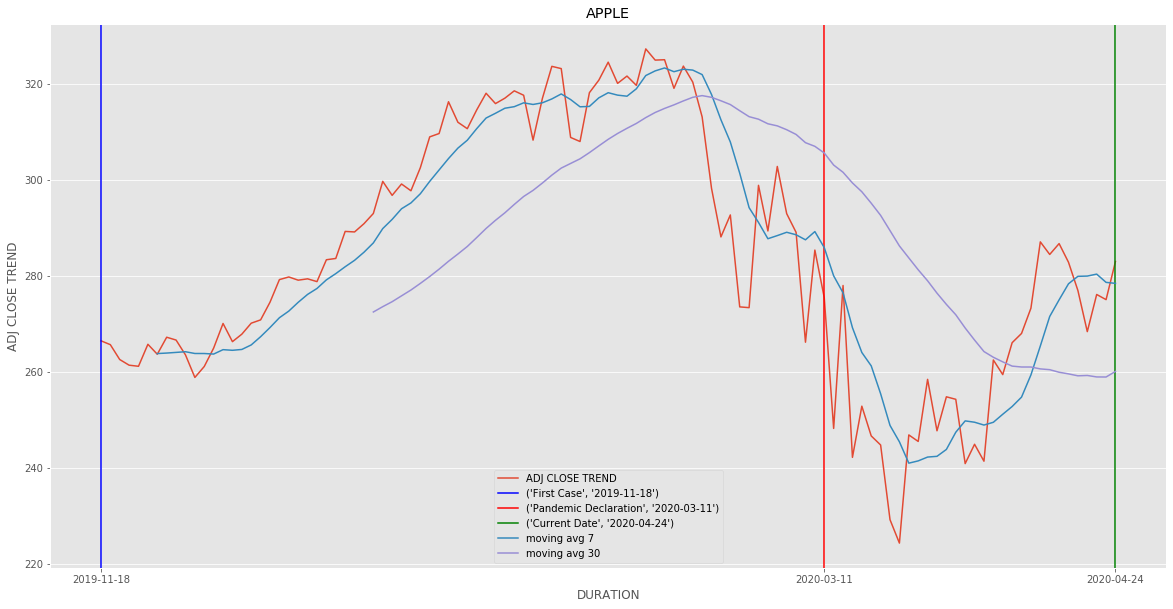

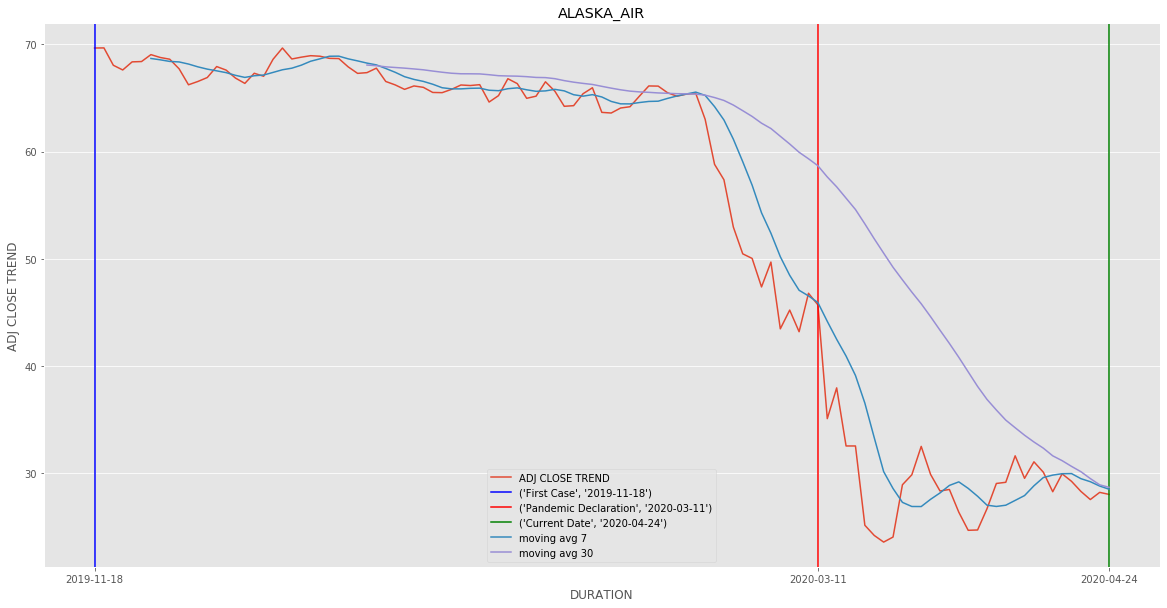

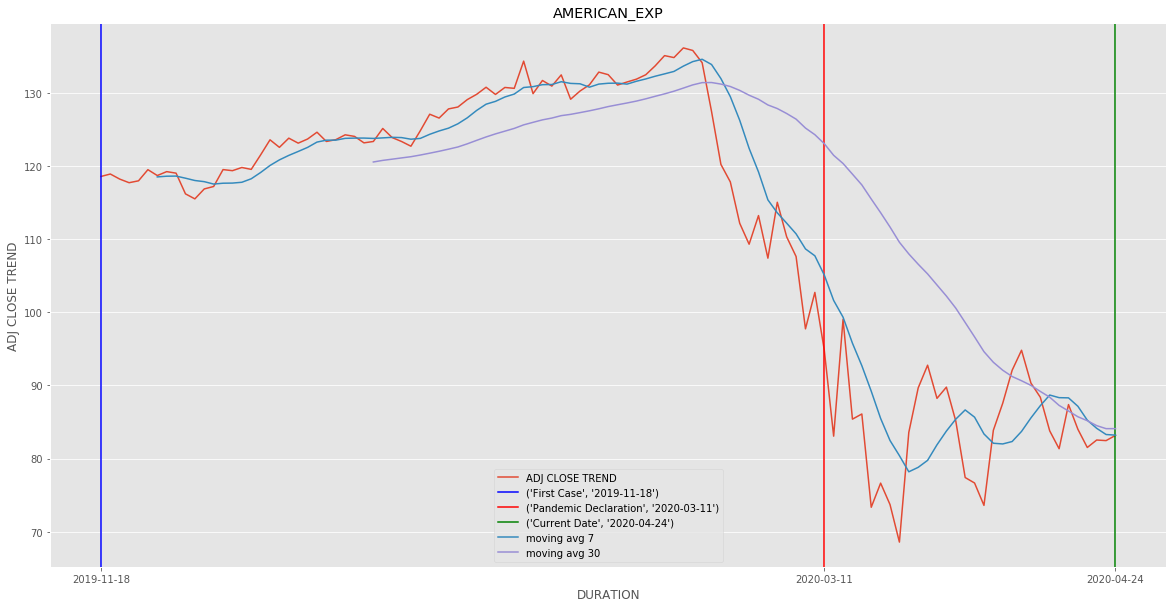

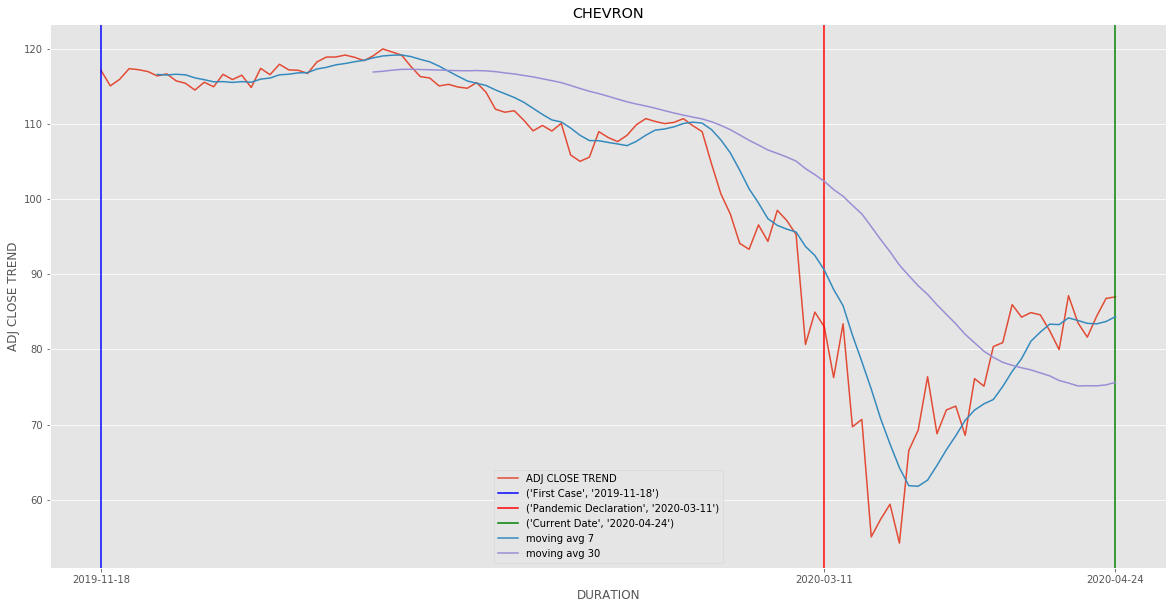

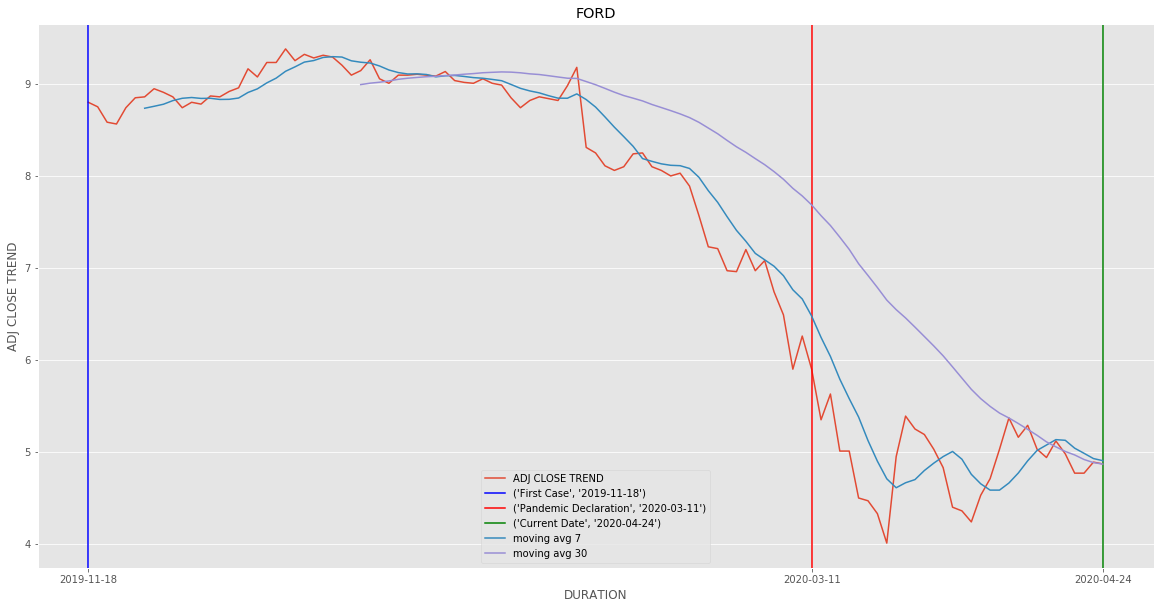

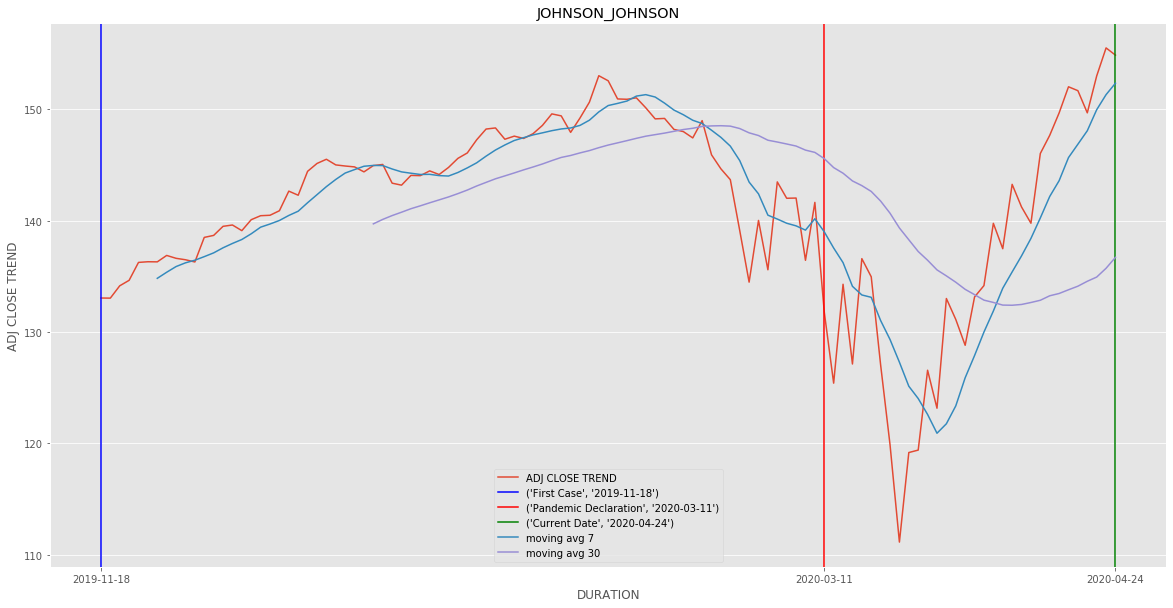

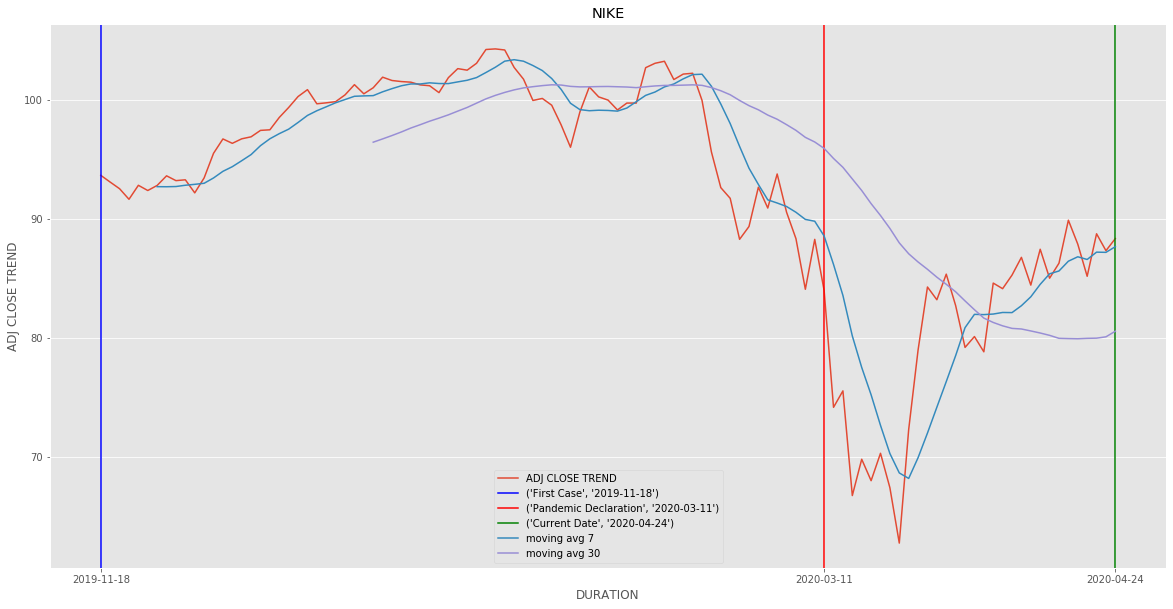

In [38]:
for i in range(len(path)):    
    plt.figure(figsize=(20,10))
    plot_any2(path[i], '2019-11-18', '2020-03-11', '2020-04-24', names[i]) 

# when shrot term MA crosses above long term MA its a buy signal 
# when sort term MA crosses below long term MA sell signal 
# https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp
# tickers = ['AAPL','AXP','NKE','CVX','JNJ','F','ALK']

Text(0.5, 1.0, 'apple')

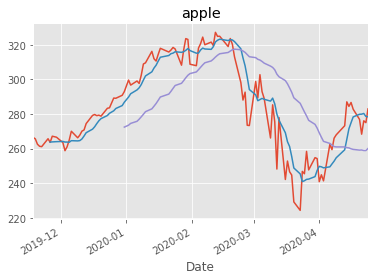

In [26]:
# apple moving average graph
aapl['Adj Close']['2019-11-17':].plot()
aapl['Adj Close']['2019-11-17':].rolling(7).mean().plot()
aapl['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('apple')

Text(0.5, 1.0, 'American Express')

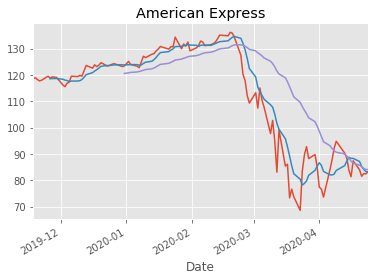

In [27]:
# american express
axp['Adj Close']['2019-11-17':].plot()
axp['Adj Close']['2019-11-17':].rolling(7).mean().plot()
axp['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('American Express')

Text(0.5, 1.0, 'Nike')

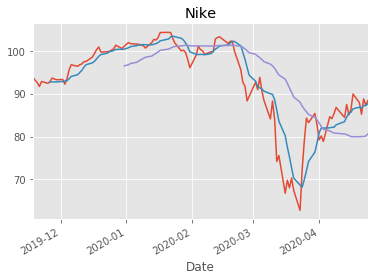

In [28]:
# Nike
nke['Adj Close']['2019-11-17':].plot()
nke['Adj Close']['2019-11-17':].rolling(7).mean().plot()
nke['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Nike')

Text(0.5, 1.0, 'Chevron')

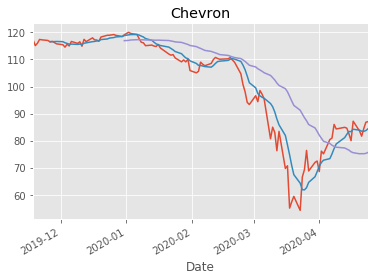

In [29]:
# Chevron
cvx['Adj Close']['2019-11-17':].plot()
cvx['Adj Close']['2019-11-17':].rolling(7).mean().plot()
cvx['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Chevron')

Text(0.5, 1.0, 'Johnson&Johnson')

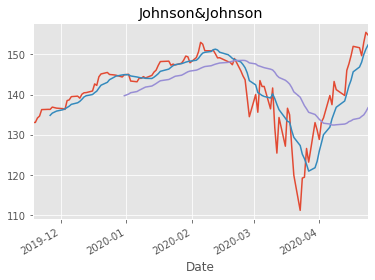

In [30]:
# JNJ
jnj['Adj Close']['2019-11-17':].plot()
jnj['Adj Close']['2019-11-17':].rolling(7).mean().plot()
jnj['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Johnson&Johnson')

Text(0.5, 1.0, 'Ford')

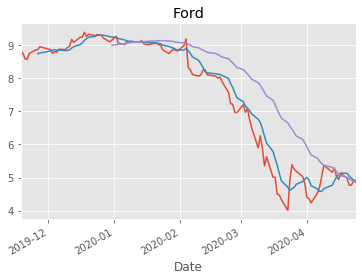

In [31]:
# JNJ
f['Adj Close']['2019-11-17':].plot()
f['Adj Close']['2019-11-17':].rolling(7).mean().plot()
f['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Ford')

Text(0.5, 1.0, 'Alaskan Airlines')

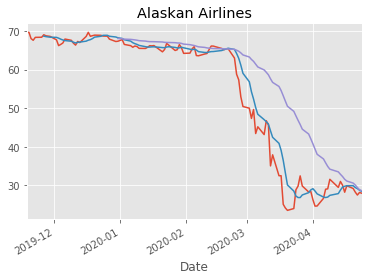

In [34]:
# JNJ
alk['Adj Close']['2019-11-17':].plot()
alk['Adj Close']['2019-11-17':].rolling(7).mean().plot()
alk['Adj Close']['2019-11-17':].rolling(30).mean().plot()
plt.title('Alaskan Airlines')

<BarContainer object of 40 artists>

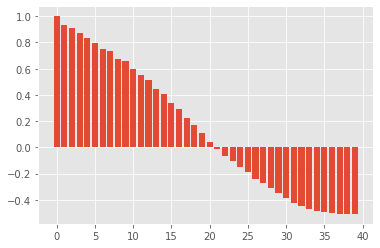

In [44]:
# autocorrelation function = acf 
acf_vals = acf(aapl['Adj Close']['2019-11-17':])
num_lags = 40
plt.bar(range(num_lags),acf_vals[:num_lags])

<BarContainer object of 20 artists>

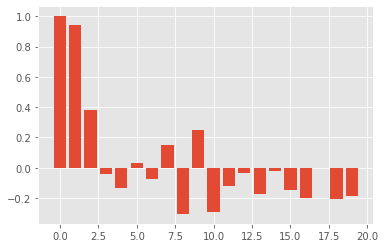

In [42]:
pacf_vals = pacf(aapl['Adj Close']['2019-11-17':])
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [45]:
# train test split 
train_end = dt.datetime(2019,12,20)
test_end = dt.datetime(2020,1,1)
train_data = aapl['Adj Close'][:train_end]
test_data = aapl['Adj Close'][train_end + timedelta(days=1):test_end]

In [48]:
# model
model = ARIMA(train_data, order = (0,0,2))

# ARIMA 
https://www.youtube.com/watch?v=o7Ux5jKEbcw 

'AAPL','AXP','NKE','CVX','JNJ','F','ALK'

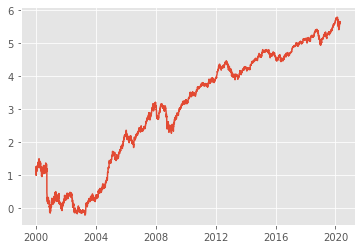

In [53]:
# taking the log of all the adjusted closing prices 

log_aapl_price = np.log(aapl['Adj Close'])
log_axp_price = np.log(axp['Adj Close'])
log_nke_price = np.log(nke['Adj Close'])
log_cvx_price = np.log(cvx['Adj Close'])
log_jnj_price = np.log(jnj['Adj Close'])
log_f_price = np.log(f['Adj Close'])
log_alk_price = np.log(alk['Adj Close'])
log_coke_price = np.log(coke['Adj Close'])





# log_jnj_price = np.log(jnj['Adj Close'])
plt.plot(log_aapl_price)
# plt.plot(aapl['Adj Close'])
# plt.plot(log_jnj_price)

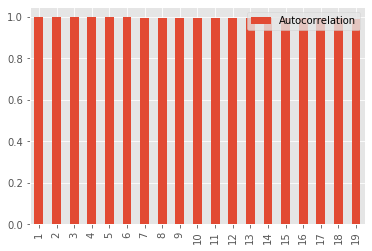

In [17]:
# auto correlation for apple 
acf_aapl = acf(log_aapl_price)[1:20]
test_aapl = pd.DataFrame([acf_aapl]).T
test_aapl.columns = ['Autocorrelation']
test_aapl.index += 1 
test_aapl.plot(kind='bar')
plt.show()

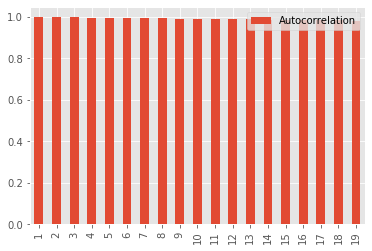

In [11]:
# auto correlation for american express 
acf_axp = acf(log_axp_price)[1:20]
test_axp = pd.DataFrame([acf_axp]).T
test_axp.columns = ['Autocorrelation']
test_axp.index += 1 
test_axp.plot(kind='bar')
plt.show()

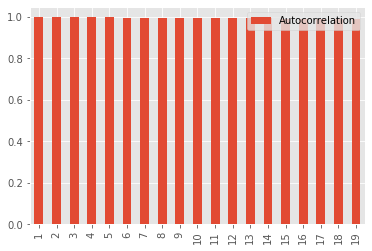

In [12]:
# auto correlation for nike 
acf_nke = acf(log_nke_price)[1:20]
test_nke = pd.DataFrame([acf_nke]).T
test_nke.columns = ['Autocorrelation']
test_nke.index += 1 
test_nke.plot(kind='bar')
plt.show()

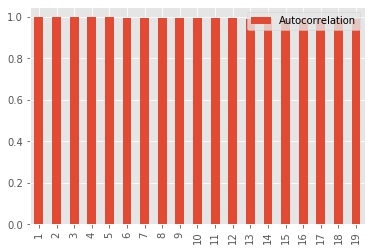

In [13]:
# auto correlation for cheveron 
acf_cvx = acf(log_cvx_price)[1:20]
test_cvx = pd.DataFrame([acf_cvx]).T
test_cvx.columns = ['Autocorrelation']
test_cvx.index += 1 
test_cvx.plot(kind='bar')
plt.show()

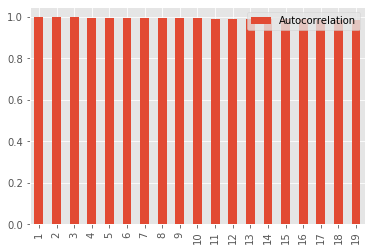

In [14]:
# auto correlation for johnson and johnson
acf_jnj = acf(log_jnj_price)[1:20]
test_jnj = pd.DataFrame([acf_jnj]).T
test_jnj.columns = ['Autocorrelation']
test_jnj.index += 1 
test_jnj.plot(kind='bar')
plt.show()

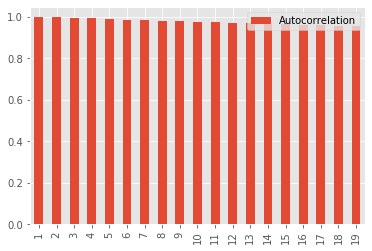

In [15]:
# auto correlation for ford
acf_f = acf(log_f_price)[1:20]
test_f = pd.DataFrame([acf_f]).T
test_f.columns = ['Autocorrelation']
test_f.index += 1 
test_f.plot(kind='bar')
plt.show()

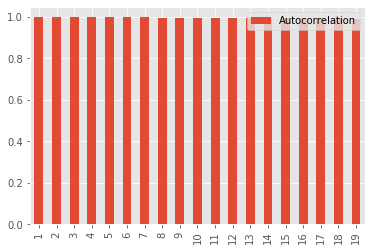

In [16]:
# auto correlation for alaskan airlies
acf_alk = acf(log_alk_price)[1:20]
test_alk = pd.DataFrame([acf_alk]).T
test_alk.columns = ['Autocorrelation']
test_alk.index += 1 
test_alk.plot(kind='bar')
plt.show()

# patrial autocorrelation

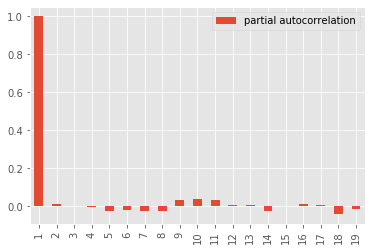

In [63]:
# partial auto correlation for apple
pacf_aapl = pacf(log_aapl_price)[1:20]
test_aapl = pd.DataFrame([pacf_aapl]).T
test_aapl.columns = ['partial autocorrelation']
test_aapl.index += 1 
test_aapl.plot(kind='bar')
plt.show()

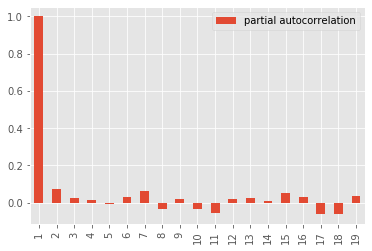

In [18]:
# partial auto correlation for amex
pacf_axp = pacf(log_axp_price)[1:20]
test_axp = pd.DataFrame([pacf_axp]).T
test_axp.columns = ['partial autocorrelation']
test_axp.index += 1 
test_axp.plot(kind='bar')
plt.show()

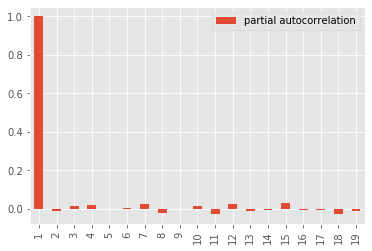

In [19]:
# partial auto correlation for nike
pacf_nke = pacf(log_nke_price)[1:20]
test_nke = pd.DataFrame([pacf_nke]).T
test_nke.columns = ['partial autocorrelation']
test_nke.index += 1 
test_nke.plot(kind='bar')
plt.show()

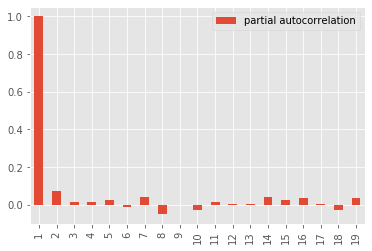

In [20]:
# partial auto correlation for Chevron
pacf_cvx = pacf(log_cvx_price)[1:20]
test_cvx = pd.DataFrame([pacf_cvx]).T
test_cvx.columns = ['partial autocorrelation']
test_cvx.index += 1 
test_cvx.plot(kind='bar')
plt.show()

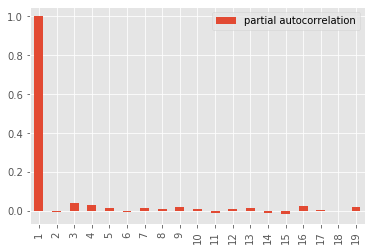

In [21]:
# partial auto correlation for jnj
pacf_jnj = pacf(log_jnj_price)[1:20]
test_jnj = pd.DataFrame([pacf_jnj]).T
test_jnj.columns = ['partial autocorrelation']
test_jnj.index += 1 
test_jnj.plot(kind='bar')
plt.show()

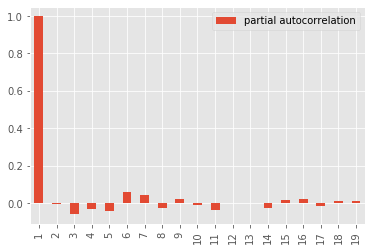

In [22]:
# partial auto correlation for ford
pacf_f = pacf(log_f_price)[1:20]
test_f = pd.DataFrame([pacf_f]).T
test_f.columns = ['partial autocorrelation']
test_f.index += 1 
test_f.plot(kind='bar')
plt.show()

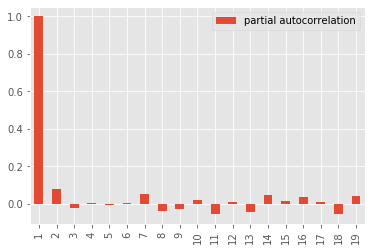

In [23]:
# partial auto correlation for alk
pacf_alk = pacf(log_alk_price)[1:20]
test_alk = pd.DataFrame([pacf_alk]).T
test_alk.columns = ['partial autocorrelation']
test_alk.index += 1 
test_alk.plot(kind='bar')
plt.show()

# dicky fuller test
not doing for all 

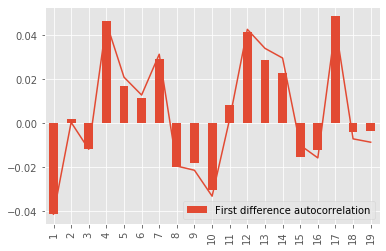

In [68]:
result = ts.adfuller(log_aapl_price,1)
result
lnprice_diff = log_aapl_price - log_aapl_price.shift()
diff = lnprice_diff.dropna()
acf_1_diff = acf(diff)[1:20]
test_df = pd.DataFrame([acf_1_diff]).T
test_df.columns = ['First difference autocorrelation']

test_df.index += 1
test_df.plot(kind='bar')
pacf_1_diff = pacf(diff)[1:20]
plt.plot(pacf_1_diff)
plt.show()


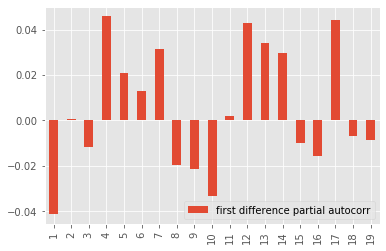

In [69]:
test_df = pd.DataFrame([pacf_1_diff]).T
test_df.columns = ['first difference partial autocorr']
test_df.index += 1
test_df.plot(kind='bar')
plt.show()

# Apple ARIMA predictions 

In [54]:
# apple ARIMA model 
price_matrix_aapl = log_aapl_price.as_matrix()
model_aapl = ARIMA(price_matrix_aapl,(0,1,0))
model_fit_aapl = model_aapl.fit(disp=0) 
print(model_fit_aapl.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               11266.736
Method:                           css   S.D. of innovations              0.027
Date:                Thu, 30 Apr 2020   AIC                         -22529.472
Time:                        17:11:40   BIC                         -22516.395
Sample:                             1   HQIC                        -22524.894
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.309      0.021       0.000       0.002


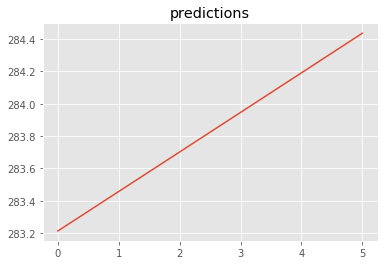

[283.21386915 283.45794724 283.70223569 283.94673467 284.19144436
 284.43636494]
             Adj Close        pred
Date                              
2020-04-27  283.170013  283.213869
2020-04-28  278.579987  283.457947
2020-04-29  287.730011  283.702236


3.6523689789443856

In [94]:
# apple ARIMA prediction 
prediction_aapl = model_fit_aapl.predict(5112,5115,typ='levels')
predictions_aapl_adj = np.exp(prediction_aapl)
plt.plot(predictions_aapl_adj)
plt.title('predictions')
plt.show()
print(predictions_aapl_adj)
# testing 

aapl_test['pred'] = predictions_aapl_adj[:3]
print(aapl_test)
# rmse_aapl = np.sqrt(mean_squared_error(predictions_aapl_adj[:3],aapl_test['Adj Close']))

rmse_aapl = np.sqrt(mean_squared_error(aapl_test['Adj Close'],aapl_test['pred']))

rmse_aapl

# American Express predictions 

In [73]:
# apple ARIMA model 
price_matrix_axp = log_axp_price.as_matrix()
model_axp = ARIMA(price_matrix_axp,(0,1,0))
model_fit_axp = model_axp.fit(disp=0) 
print(model_fit_axp.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               12056.421
Method:                           css   S.D. of innovations              0.023
Date:                Thu, 30 Apr 2020   AIC                         -24108.841
Time:                        17:25:47   BIC                         -24095.764
Sample:                             1   HQIC                        -24104.263
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.544      0.586      -0.000       0.001


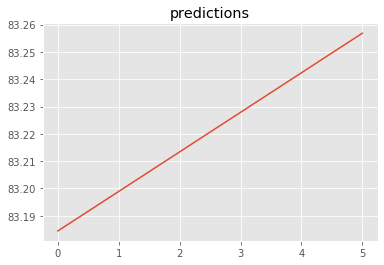

[83.18446758 83.19893951 83.21341396 83.22789092 83.24237041 83.25685241]
            Adj Close       pred
Date                            
2020-04-27  85.059998  83.184468
2020-04-28  88.190002  83.198940
2020-04-29  96.120003  83.213414
RMSE: 8.062430486011628


In [95]:
# American Express ARIMA prediction 
prediction_axp = model_fit_axp.predict(5112,5115,typ='levels')
predictions_axp_adj = np.exp(prediction_axp)
plt.plot(predictions_axp_adj)
plt.title('predictions')
plt.show()
print(predictions_axp_adj)
axp_test['pred'] = predictions_axp_adj[:3]
print(axp_test)
rmse_axp = np.sqrt(mean_squared_error(axp_test['Adj Close'],axp_test['pred']))
# rmse_axp = np.sqrt(mean_squared_error(predictions_axp_adj[:3],axp_test['Adj Close']))
print("RMSE:",rmse_axp)

# Nike predictions

In [76]:
# nike ARIMA model 
price_matrix_nke = log_nke_price.as_matrix()
model_nke = ARIMA(price_matrix_nke,(0,1,0))
model_fit_nke = model_nke.fit(disp=0) 
print(model_fit_nke.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               12940.961
Method:                           css   S.D. of innovations              0.019
Date:                Thu, 30 Apr 2020   AIC                         -25877.923
Time:                        17:26:36   BIC                         -25864.845
Sample:                             1   HQIC                        -25873.344
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.820      0.005       0.000       0.001


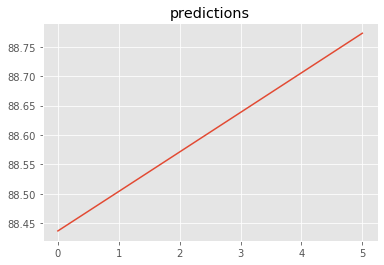

[88.43703766 88.50412342 88.57126008 88.63844766 88.7056862  88.77297576]
            Adj Close       pred
Date                            
2020-04-27  89.370003  88.437038
2020-04-28  88.800003  88.504123
2020-04-29  88.070000  88.571260
RMSE: 0.6348833431424756


In [98]:
# Nike ARIMA prediction 
prediction_nke = model_fit_nke.predict(5112,5115,typ='levels')
predictions_nke_adj = np.exp(prediction_nke)
plt.plot(predictions_nke_adj)
plt.title('predictions')
plt.show()
print(predictions_nke_adj)
nke_test['pred'] = predictions_nke_adj[:3]
print(nke_test)
rmse_nke = np.sqrt(mean_squared_error(nke_test['Adj Close'],nke_test['pred']))
# rmse_axp = np.sqrt(mean_squared_error(predictions_axp_adj[:3],axp_test['Adj Close']))
print("RMSE:",rmse_nke)



# rmse_nke = np.sqrt(mean_squared_error(predictions_nke_adj[:3],nke_test['Adj Close']))
# print(rmse_nke)

# Chevron predictions 

In [78]:
# Chevron ARIMA model 
price_matrix_cvx = log_cvx_price.as_matrix()
model_cvx = ARIMA(price_matrix_cvx,(0,1,0))
model_fit_cvx = model_cvx.fit(disp=0) 
print(model_fit_cvx.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               13481.118
Method:                           css   S.D. of innovations              0.017
Date:                Thu, 30 Apr 2020   AIC                         -26958.235
Time:                        17:27:11   BIC                         -26945.158
Sample:                             1   HQIC                        -26953.657
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.302      0.193      -0.000       0.001


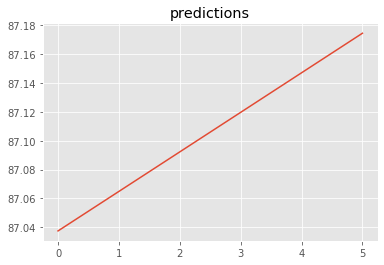

[87.03739919 87.06480487 87.09221918 87.11964212 87.14707369 87.1745139 ]
            Adj Close       pred
Date                            
2020-04-27  89.709999  87.037399
2020-04-28  89.910004  87.064805
2020-04-29  94.620003  87.092219
RMSE: 4.895762517551652


In [99]:
# Chevron ARIMA prediction 
prediction_cvx = model_fit_cvx.predict(5112,5115,typ='levels')
predictions_cvx_adj = np.exp(prediction_cvx)
plt.plot(predictions_cvx_adj)
plt.title('predictions')
plt.show()
print(predictions_cvx_adj)
cvx_test['pred'] = predictions_cvx_adj[:3]
print(cvx_test)
rmse_cvx = np.sqrt(mean_squared_error(cvx_test['Adj Close'],cvx_test['pred']))
# rmse_axp = np.sqrt(mean_squared_error(predictions_axp_adj[:3],axp_test['Adj Close']))
print("RMSE:",rmse_cvx)


# rmse_cvx = np.sqrt(mean_squared_error(predictions_cvx_adj[:3],cvx_test['Adj Close']))
# print(rmse_cvx)

# Johnson&Johnson predictions 

In [80]:
# Johnson & Johnson ARIMA model 
price_matrix_jnj = log_jnj_price.as_matrix()
model_jnj = ARIMA(price_matrix_jnj,(0,1,0))
model_fit_jnj = model_jnj.fit(disp=0) 
print(model_fit_jnj.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               15153.027
Method:                           css   S.D. of innovations              0.012
Date:                Thu, 30 Apr 2020   AIC                         -30302.054
Time:                        17:27:43   BIC                         -30288.977
Sample:                             1   HQIC                        -30297.476
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.962      0.050    3.52e-07       0.001


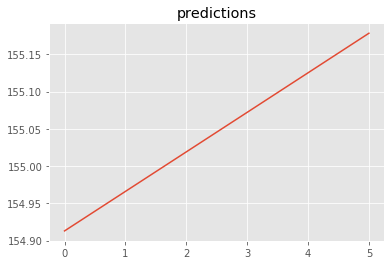

[154.91299236 154.96600225 155.01903027 155.07207644 155.12514076
 155.17822324]
             Adj Close        pred
Date                              
2020-04-27  154.289993  154.912992
2020-04-28  151.389999  154.966002
2020-04-29  150.240005  155.019030
RMSE: 3.4648233291035058


In [100]:
# Johnson & Johnson ARIMA prediction 
prediction_jnj = model_fit_jnj.predict(5112,5115,typ='levels')
predictions_jnj_adj = np.exp(prediction_jnj)
plt.plot(predictions_jnj_adj)
plt.title('predictions')
plt.show()
print(predictions_jnj_adj)

jnj_test['pred'] = predictions_jnj_adj[:3]
print(jnj_test)
rmse_jnj = np.sqrt(mean_squared_error(jnj_test['Adj Close'],jnj_test['pred']))
print("RMSE:",rmse_jnj)

# rmse_jnj = np.sqrt(mean_squared_error(predictions_jnj_adj[:3],jnj_test['Adj Close']))
# print(rmse_jnj)

# Ford predictions

In [86]:
# Ford ARIMA model 
price_matrix_f = log_f_price.as_matrix()
model_f = ARIMA(price_matrix_f,(0,1,0))
model_fit_f = model_f.fit(disp=0) 
print(model_fit_f.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               11311.800
Method:                           css   S.D. of innovations              0.026
Date:                Thu, 30 Apr 2020   AIC                         -22619.599
Time:                        17:29:03   BIC                         -22606.522
Sample:                             1   HQIC                        -22615.021
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.597      0.550      -0.001       0.001


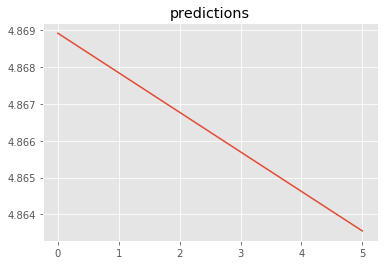

[4.86892396 4.86784828 4.86677283 4.86569763 4.86462266 4.86354792]
            Adj Close      pred
Date                           
2020-04-27       5.17  4.868924
2020-04-28       5.38  4.867848
2020-04-29       5.26  4.866773
RMSE: 0.41132878574101567


In [101]:
# Ford ARIMA prediction 
prediction_f = model_fit_f.predict(5110,5115,typ='levels')
predictions_f_adj = np.exp(prediction_f)
plt.plot(predictions_f_adj)
plt.title('predictions')
plt.show()
print(predictions_f_adj)


f_test['pred'] = predictions_f_adj[:3]
print(f_test)
rmse_f = np.sqrt(mean_squared_error(f_test['Adj Close'],f_test['pred']))
print("RMSE:",rmse_f)


# rmse_f = np.sqrt(mean_squared_error(predictions_f_adj[:3],f_test['Adj Close']))
# print(rmse_f)

# Alaskan Airlines predictions

In [88]:
# Alaskan Airlines ARIMA model 
price_matrix_alk = log_alk_price.as_matrix()
model_alk = ARIMA(price_matrix_alk,(0,1,0))
model_fit_alk = model_alk.fit(disp=0) 
print(model_fit_alk.summary())

ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 5109
Model:                 ARIMA(0, 1, 0)   Log Likelihood               10911.514
Method:                           css   S.D. of innovations              0.029
Date:                Thu, 30 Apr 2020   AIC                         -21819.028
Time:                        17:29:26   BIC                         -21805.951
Sample:                             1   HQIC                        -21814.450
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.631      0.528      -0.001       0.001


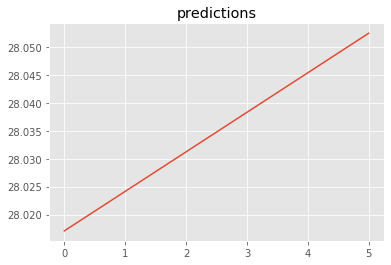

[28.01707159 28.02414473 28.03121966 28.03829638 28.04537488 28.05245517]
            Adj Close       pred
Date                            
2020-04-27      27.85  28.017072
2020-04-28      31.58  28.024145
2020-04-29      34.00  28.031220
RMSE: 4.012412311670917


In [102]:
# Alaskan Airlines ARIMA prediction 
prediction_alk = model_fit_alk.predict(5110,5115,typ='levels')
predictions_alk_adj = np.exp(prediction_alk)
plt.plot(predictions_alk_adj)
plt.title('predictions')
plt.show()
print(predictions_alk_adj)

alk_test['pred'] = predictions_alk_adj[:3]
print(alk_test)
rmse_alk = np.sqrt(mean_squared_error(alk_test['Adj Close'],alk_test['pred']))
print("RMSE:",rmse_alk)



# rmse_f = np.sqrt(mean_squared_error(predictions_f_adj[:3],f_test['Adj Close']))
# print(rmse_f)